<a href="https://colab.research.google.com/github/Sejong-Kaggle-Challengers/jeongmin/blob/main/KCB_%EA%B8%88%EC%9C%B5%EC%8A%A4%ED%83%80%EC%9D%BC_%EC%8B%9C%EA%B0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### KCB(올크레딧) - 신용평가사
다양한 금융사로부터 여신거래 기록, 채무 정보, 연체정보 등  다양한 고객 금융 정보를 받아 전국민 85.4%인 4,400만 경제활동 인구의
경제 활동 데이터를 보유하고 있으며, 이를 통해 개인 신용 등급 책정 및 솔루션/컨설팅 서비스를 제공
<br><br>
대회 목적 :
1. KCB 전국민 금융 데이터의 새로운 인사이트 발굴
2. 활용도 높은 결과물로 금융친화적 콘텐츠 발전에 기여
<br><br>
credit_card_data.csv : 전국민 카드 및 대출 이용통계 데이터
연령대/거주지/성별 구분에 따른 카드 및 대출 이용통계 데이터로, 구분 값 별 카드이용금액 비교, 대출금액 및 대출 특이사항 비교 등이 가능하다.

In [104]:
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
!unzip data08.zip

Archive:  data08.zip
  inflating: KCB 대회 약관.pdf  
  inflating: credit_card_data.csv    
  inflating: jeju_financial_life_data.csv  


In [ ]:
!pip install eli5

     |████████████████████████████████| 112kB 5.4MB/s 


In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 5.7MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489404 sha256=be0e193532db602e1eb7842f70e2a1f6312c4d770b32bf4aca4d39790337cc25
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


In [2]:
import pandas as pd #분석
import matplotlib.pyplot as plt #시각화
import seaborn as sns #시각화
import numpy as np#분석

#경고메세지 무시
import warnings
warnings.filterwarnings('ignore')

#%matplotlib inline --> Rich output 를 바로 볼 수 있도록 (colab 에서는 굳이 쓰지 않아도 되는 것 같다)
color = sns.color_palette() #팔레트

#모델
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

#Permutation Importance를 통해 변수의 중요도를 알아볼 수 있다.
import eli5
from eli5.sklearn import PermutationImportance

#Shap Value는 실제값과 예측치의 차이를 설명하는 것
import shap

In [3]:
plt.rcParams["figure.facecolor"] = 'w' # background color = white
plt.rcParams["font.family"] = 'NanumBarunGothic' #글꼴 설정 = 나눔고딕
plt.rcParams['axes.unicode_minus'] = False #그래프에서 마이너스 기호가 깨지지 않고 표시되도록

In [4]:
train = pd.read_csv("credit_card_data.csv")
train.shape

(3888, 26)

In [5]:
train.head()

,pop_cd,year,month,avg_score,avg_rat,city,sex,ages,population,num_opencard,num_usecard,monthly_card_spend,monthly_lc,monthly_loan,monthly_bk_loan,monthly_cd_loan,monthly_installments_loan,monthly_insurance_loan,monthly_sbk_loan,loan_commitment,inst_rep_loanb,ls_rep_loanb,credit_loan,mortgage_loan,credit_card_payment,credit_card_installments_payment
0,L011,2016,1,812,2,서울,NaN,10대,55000,1.44,1.13,70000,92630000,87350000,85790000,0,0,0,0,1120000,8210000,78020000,92170000,87260000,0,0
1,L011,2016,2,773,4,서울,NaN,10대,380000,1.71,0.96,170000,31140000,28910000,25850000,190000,510000,220000,1020000,680000,4660000,23300000,8260000,42410000,4000,1000
2,L011,2016,3,771,4,서울,NaN,10대,387000,1.75,0.95,190000,30230000,28180000,25110000,170000,490000,210000,1140000,640000,4370000,22930000,8300000,41710000,3000,1000
3,L011,2016,4,770,4,서울,NaN,10대,412000,1.76,0.92,200000,30430000,27710000,24630000,190000,510000,240000,1340000,510000,4770000,22160000,9460000,41040000,4000,1000
4,L011,2016,5,771,4,서울,NaN,10대,414000,1.75,0.94,170000,31210000,27620000,24390000,210000,490000,340000,1490000,640000,4740000,21960000,9660000,40850000,3000,1000


Nan으로 표현된 부분
- 지역별 통계 : city가 값이 있는 경우는 sex가 Nan --> sex = 전체
- 성별 통계 : sex가 값이 있는 경우는 city가 Nan --> city = 전국



In [6]:
#city와 sex에서 Nan값
train.isnull().sum()

pop_cd                                 0
year                                   0
month                                  0
avg_score                              0
avg_rat                                0
city                                 432
sex                                 3456
ages                                   0
population                             0
num_opencard                           0
num_usecard                            0
monthly_card_spend                     0
monthly_lc                             0
monthly_loan                           0
monthly_bk_loan                        0
monthly_cd_loan                        0
monthly_installments_loan              0
monthly_insurance_loan                 0
monthly_sbk_loan                       0
loan_commitment                        0
inst_rep_loanb                         0
ls_rep_loanb                           0
credit_loan                            0
mortgage_loan                          0
credit_card_paym

In [7]:
train['city'] = train['city'].fillna('전국')
train['sex'] = train['sex'].fillna('전체')

- 나이별 통계 --> 연산의 용이성을 위해 숫자로 변환
- 연도, 월 데이터는 python의 datatime 포맷으로 변환하여 새로운 열 year_month로 변환

In [8]:
train['ages'][0][:-1]

'10'

In [9]:
train['ages'] = train['ages'].apply(lambda x:int(x[:-1])).astype(float)
train['year_month'] = pd.to_datetime((train.year*100+train.month).apply(str), format = '%Y%m')
train.drop(['year','month'], axis=1, inplace=True) #원래 year, month 행 drop
#year_month 행을 이전의 year과 month 자리인 행 2번째로 자리를 변경해 train을 완성한다.
train = train[[train.columns[0], 'year_month'] + list(train.columns[1:-1])]

In [10]:
train.head()

,pop_cd,year_month,avg_score,avg_rat,city,sex,ages,population,num_opencard,num_usecard,monthly_card_spend,monthly_lc,monthly_loan,monthly_bk_loan,monthly_cd_loan,monthly_installments_loan,monthly_insurance_loan,monthly_sbk_loan,loan_commitment,inst_rep_loanb,ls_rep_loanb,credit_loan,mortgage_loan,credit_card_payment,credit_card_installments_payment
0,L011,2016-01-01,812,2,서울,전체,10.0,55000,1.44,1.13,70000,92630000,87350000,85790000,0,0,0,0,1120000,8210000,78020000,92170000,87260000,0,0
1,L011,2016-02-01,773,4,서울,전체,10.0,380000,1.71,0.96,170000,31140000,28910000,25850000,190000,510000,220000,1020000,680000,4660000,23300000,8260000,42410000,4000,1000
2,L011,2016-03-01,771,4,서울,전체,10.0,387000,1.75,0.95,190000,30230000,28180000,25110000,170000,490000,210000,1140000,640000,4370000,22930000,8300000,41710000,3000,1000
3,L011,2016-04-01,770,4,서울,전체,10.0,412000,1.76,0.92,200000,30430000,27710000,24630000,190000,510000,240000,1340000,510000,4770000,22160000,9460000,41040000,4000,1000
4,L011,2016-05-01,771,4,서울,전체,10.0,414000,1.75,0.94,170000,31210000,27620000,24390000,210000,490000,340000,1490000,640000,4740000,21960000,9660000,40850000,3000,1000


- 유니크 갯수 계산을 통한 변수 값의 다양성 분석

In [11]:
train_unique = []
for i in train.columns.values:
  train_unique.append(len(train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = list(train.columns)
unique_train['Unique_value'] = train_unique

In [12]:
unique_train

,Columns,Unique_value
0,pop_cd,162
1,year_month,24
2,avg_score,117
3,avg_rat,3
4,city,17
5,sex,3
6,ages,9
7,population,1077
8,num_opencard,456
9,num_usecard,256


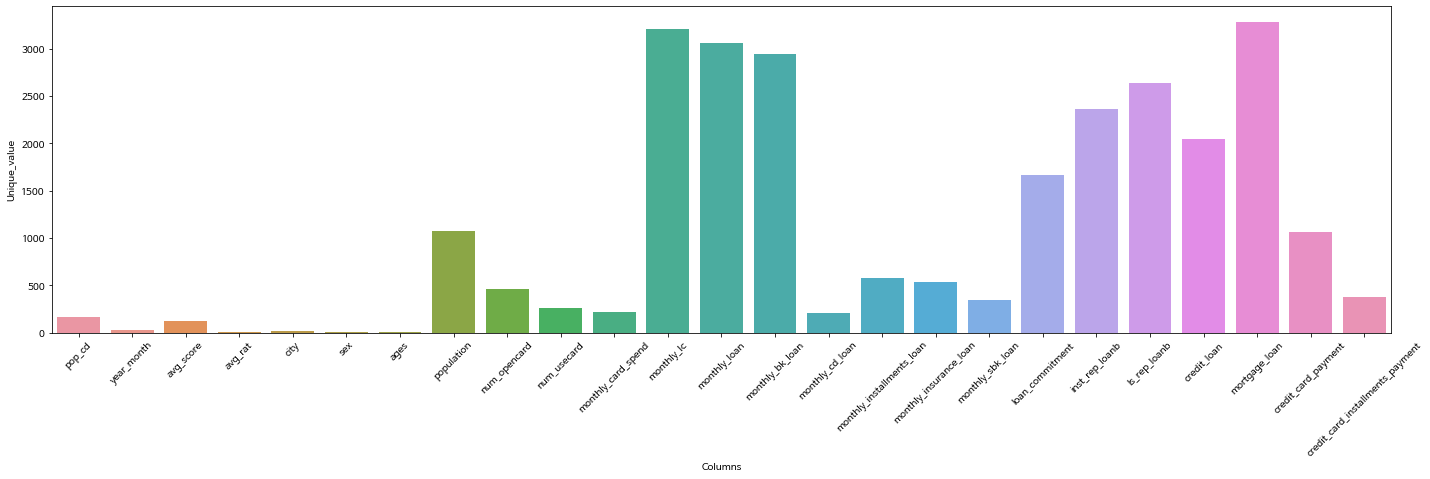

In [13]:
plt.figure(figsize = (24, 6))
sns.barplot(unique_train['Columns'], unique_train['Unique_value'])
xt = plt.xticks(rotation = 45) #x축 column명 45도로 회전시켜 겹치는 것을 피한다.

#원 코드에서는 아래처럼 쓰여있음 --> 이해 제대로 못함..
#xt = plt.xticks()
#_ = plt.xticks(xt[0], train.columns, rotation = 45)

##상관관계 분석
데이터 컬럼 사이의 상관관계를 계산해 비례함의 정도를 보인다.
<br>양의 상관관계가 클 수록 비례관계, 음의 상관관계가 클수록 반비례관계이며<br> 0에 가까우면 서로 독립으로 볼 수 있다.

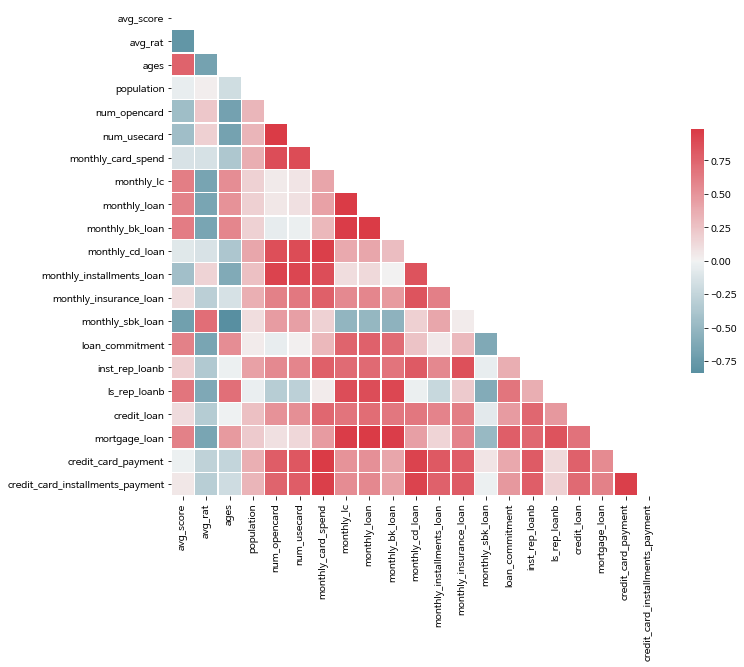

In [14]:
corr = train.corr()

#삼각형 마스크를 만든다.(위쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Heatmap 그리기 - mask and correct aspect ratio  사용
sns.heatmap(corr, mask = mask, cmap = cmap, center = 0, square=True, linewidths=.5, cbar_kws={"shrink":.5})

plt.show()

In [15]:
corr = train.corr().unstack().sort_values(ascending=False).drop_duplicates()
corr.drop(corr.index[0],inplace=True) #credit_card_installments_payment drop

display(corr.head())
display(corr.tail(5))

monthly_loan         monthly_lc            0.986415
credit_card_payment  monthly_card_spend    0.985854
mortgage_loan        monthly_loan          0.985699
num_usecard          num_opencard          0.983744
monthly_loan         monthly_bk_loan       0.980280
dtype: float64

ages              num_usecard        -0.679487
num_opencard      ages               -0.688015
avg_score         monthly_sbk_loan   -0.701963
avg_rat           avg_score          -0.786341
monthly_sbk_loan  ages               -0.841758
dtype: float64

대출 약정 금액 : 최대로 대출 받을 한도를 설정해두고 대출약정금액을 포함한 가격까지 대출이 가능

**양수(+)에서 가장 상관관계가 높은 5쌍**
- monthly_loan(대출 금액), monthly_lc(대출약정금액)  <br>대출금액은 대출약정금액에 포함, 대출약정이 많을수록 대출 발생도 많이 했으므로 마이너스 통장과 같은 대출 발생 금액은 상대적으로 적다고 할 수 있다.
- credit_card_payment(신용카드사용금액),  monthly_card_spend(총카드승인금액) <br>신용카드 사용 금액은 총 카드 승인 금액에 포함, 상관관계가 1에 가깝다는 것은 체크카드 사용량이 적다는 것을 알 수 있다.
- mortgage_loan(담보대출), monthly_loan(대출금액) <br>담보 대출은 대출 금액에 포함, 상관관계가 1에 가깝다는 것은 대출의 상당수가 담보 대출이라는 것을 알 수 있다.
- num_usecard(사용카드수), num_opencard(개설한카드수)<br> 개설한 카드 수와 사용 카드 수가 비례하므로 유휴 카드가 많지 않다고 해석할 수 있다.
- monthly_loan(대출금액)   monthly_bk_loan(은행대출)<br>은행 대출은 대출 금액에 포함, 상관관계가 1에 가깝다는 것은 대출의 상당수가 은행 대출이라는 것을 알 수 있다.

**음수(-)에서 가장 상관관계가 높은 5쌍**
- ages              num_usecard        -0.679487 <br>상관관계에 따르면 나이가 높을수록 사용하는 카드의 수가 적다. 고령으로 갈수록 필요한 카드만 사용한다고 볼 수 있다.
- num_opencard      ages               -0.688015 <br>나이와 사용카드의 관계와 동일하게 해석 가능하다
- avg_score         monthly_sbk_loan   -0.701963 <br>저축은행 대출이 낮을수록 신용점수가 높다.
- avg_rat           avg_score          -0.786341 <br>신용점수가 높을수록 높은 등급을 받는 것은 당연하지만, 등급이 높을수록 숫자가 낮아 음의 상관관계를 가진다.
- monthly_sbk_loan  ages               -0.841758 <br>나이가 낮을수록 저축은행 대출이 높다.

###연령별/지역별 상관관계 분석
전체 데이터의 상관관계가 연령, 지역별로도 적용되는지 확인하기 위해 데이터를 그룹에 따라 모아서 평균 신용점수(avg_score)에 대해서만 상관관계를 분석해보았다.

연령별 상관관계 분석

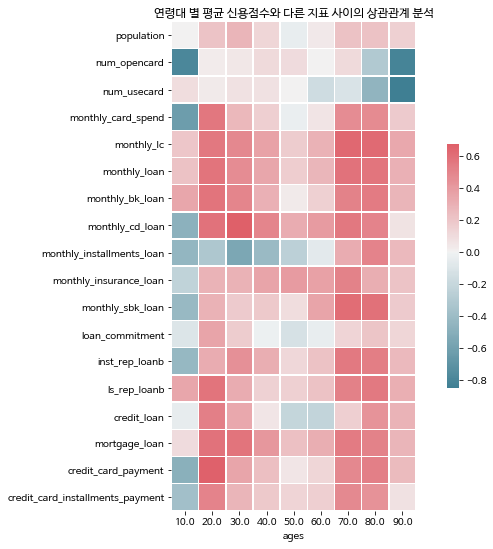

In [16]:
corr = train[train.columns[1:]].groupby('ages').corr()['avg_score'].fillna(0).unstack()
mask = np.zeros_like(corr, dtype=np.bool)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.T[2:],  cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('연령대 별 평균 신용점수와 다른 지표 사이의 상관관계 분석')
plt.show()

지역별 상관관계 분석

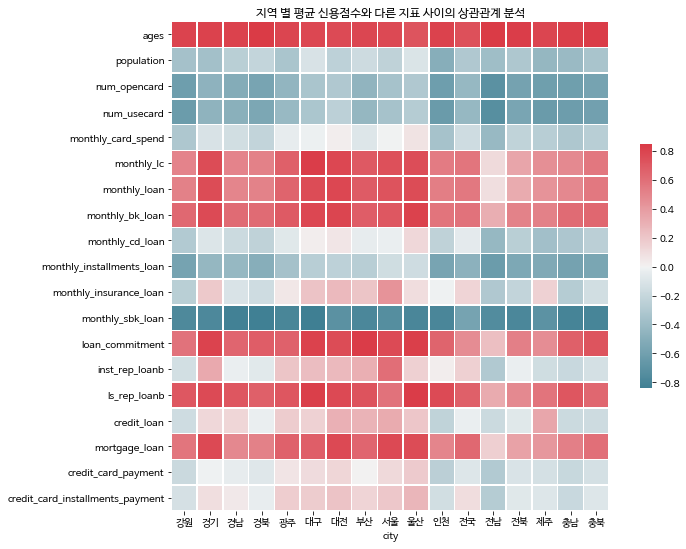

In [21]:
corr = train[train.columns[1:]].groupby('city').corr()['avg_score'].fillna(0).unstack()
mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.T[2:],  cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('지역 별 평균 신용점수와 다른 지표 사이의 상관관계 분석')
plt.show()

위 분석에 따르면 신용점수와의 상관관계는 지역에 따라서는 큰 편차가 없지만 연령에 따라서는 편차가 큰 것으로 보인다.